In [1]:
from gtm import *

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# GTM Package including GTM and the plot functions
from gtm import *
# Sample Copulas Package
import pyvinecopulib as pv
import numpy as np
# Other Stuff
import torch
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Sample Data

In [3]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [4]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_74378/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_74378/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_74378/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

In [5]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [6]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_74378/2452348847.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_74378/2452348847.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_74378/2452348847.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requir

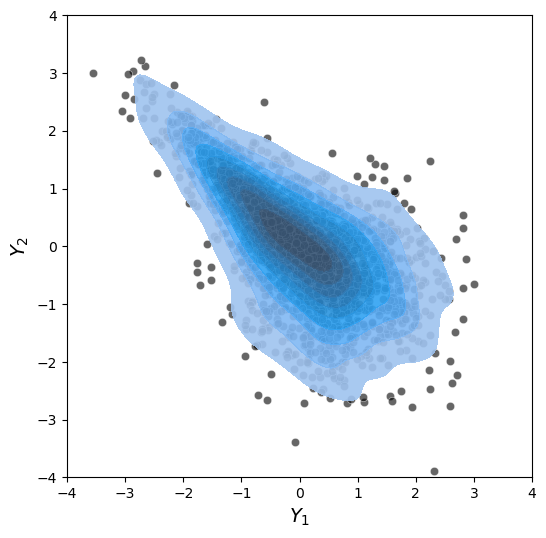

In [7]:
_ = plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

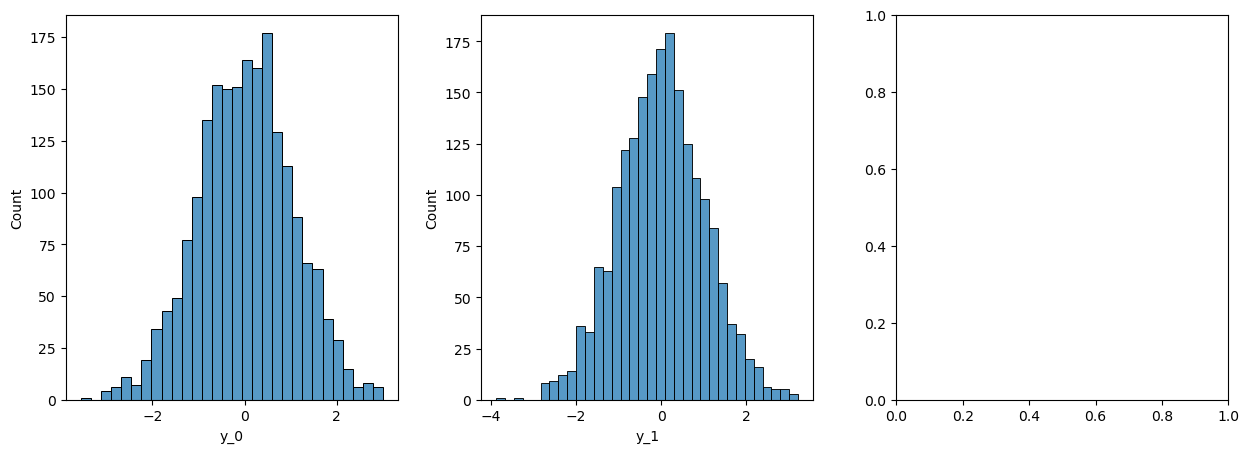

In [8]:
_ = plot_marginals(simulated_data_train)

In [9]:
class Copula_2D_Dataset(Dataset):
    def __init__(self, data):
        
        # First Dimension (N) needs to be the samples
        # Second Dimension (D) is the dimensionality of the data
        self.data = data
    
    def __len__(self):
        return self.data.size(0)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
# Create dataset and DataLoader
dataset_train = Copula_2D_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Copula_2D_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

In [10]:
# Here you can see that we load the full data, so not batches
# Model is just implemented with dataloaders because that is eeded for huge datasets in bioinformatics
data_iter = iter(dataloader_train)
sample = next(data_iter)
sample.size()

torch.Size([2000, 2])

### 2. Define Model

In [11]:
model = GTM(
    degree_decorrelation=20,
    degree_transformations=15,
    num_decorr_layers=3,
    num_trans_layers=1,
    number_variables=2,
    device="cpu") 

### 3. Hyperparameter Tune and Train Model

In [12]:
study = model.hyperparameter_tune_penalties( 
                                train_dataloader=dataloader_train, 
                                validate_dataloader=dataloader_validate, 
                                penvalueridge = [0], #["sample"],
                                penfirstridge = ["sample"],
                                pensecondridge = ["sample"],
                                ctm_pensecondridge = ["sample"],
                                lambda_penalty_params = [0], #["sample"],
                                train_covariates=False, 
                                validate_covariates=False, 
                                adaptive_lasso_weights_matrix = False,
                                learning_rate=1, 
                                iterations=1000, 
                                patience=5, 
                                min_delta=1e-7, 
                                optimizer='LBFGS', 
                                lambda_penalty_mode="square", 
                                objective_type="negloglik", 
                                seperate_copula_training=False,
                                max_batches_per_iter=False,
                                tuning_mode="optuna",
                                cross_validation_folds=False,
                                random_state_KFold=42,
                                device=None,
                                pretrained_transformation_layer=False,
                                n_trials=20,
                                temp_folder=".", 
                                study_name=None)
    
penalty_params=torch.FloatTensor([
                            0, #study.best_params["penvalueridge"],
                            study.best_params["penfirstridge"],
                            study.best_params["pensecondridge"],
                            study.best_params["ctm_pensecondridge"]
                              ])
adaptive_lasso_weights_matrix = False
lambda_penalty_params=False

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-21 15:16:38,441] A new study created in RDB with name: no-name-a5b0b0f6-6ed3-46cf-8d28-22d1a16bd287


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 7.00400183596962e-06   pensecondridge_opt: 1.22326197550526   ctm_pensecondridge_opt: 2.5515898537506145   lambda_penalty_params_opt: 0


  7%|▋         | 72/1000 [00:02<00:30, 30.45it/s]
[I 2025-05-21 15:16:41,448] Trial 0 finished with value: -2.5126380920410156 and parameters: {'penfirstridge': 7.00400183596962e-06, 'pensecondridge': 1.22326197550526, 'ctm_pensecondridge': 2.5515898537506145}. Best is trial 0 with value: -2.5126380920410156.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 8.555559003097903   pensecondridge_opt: 0.07422817328153536   ctm_pensecondridge_opt: 1.0254743653498951e-07   lambda_penalty_params_opt: 0


  2%|▏         | 18/1000 [00:00<00:32, 30.07it/s]
[I 2025-05-21 15:16:42,087] Trial 1 finished with value: -2.601578712463379 and parameters: {'penfirstridge': 8.555559003097903, 'pensecondridge': 0.07422817328153536, 'ctm_pensecondridge': 1.0254743653498951e-07}. Best is trial 0 with value: -2.5126380920410156.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.001692143557614724   pensecondridge_opt: 0.003325648227065782   ctm_pensecondridge_opt: 3.5626623703786544   lambda_penalty_params_opt: 0


  4%|▎         | 37/1000 [00:01<00:32, 29.19it/s]
[I 2025-05-21 15:16:43,390] Trial 2 finished with value: -2.4608094692230225 and parameters: {'penfirstridge': 0.001692143557614724, 'pensecondridge': 0.003325648227065782, 'ctm_pensecondridge': 3.5626623703786544}. Best is trial 2 with value: -2.4608094692230225.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.003813819880893328   pensecondridge_opt: 0.0038590506014703776   ctm_pensecondridge_opt: 0.006762115290989777   lambda_penalty_params_opt: 0


  7%|▋         | 66/1000 [00:02<00:33, 27.94it/s]
[I 2025-05-21 15:16:45,791] Trial 3 finished with value: -2.460869312286377 and parameters: {'penfirstridge': 0.003813819880893328, 'pensecondridge': 0.0038590506014703776, 'ctm_pensecondridge': 0.006762115290989777}. Best is trial 2 with value: -2.4608094692230225.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 2.4915790732762096e-05   pensecondridge_opt: 1.3247821638814736e-07   ctm_pensecondridge_opt: 0.00029301448742121816   lambda_penalty_params_opt: 0


  3%|▎         | 27/1000 [00:00<00:34, 27.99it/s]
[I 2025-05-21 15:16:46,792] Trial 4 finished with value: -2.471458911895752 and parameters: {'penfirstridge': 2.4915790732762096e-05, 'pensecondridge': 1.3247821638814736e-07, 'ctm_pensecondridge': 0.00029301448742121816}. Best is trial 2 with value: -2.4608094692230225.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 8.215719940725029e-07   pensecondridge_opt: 1.0543298959729337e-07   ctm_pensecondridge_opt: 1.0162301889352648e-07   lambda_penalty_params_opt: 0


  3%|▎         | 34/1000 [00:01<00:35, 27.52it/s]
[I 2025-05-21 15:16:48,064] Trial 5 finished with value: -2.4682161808013916 and parameters: {'penfirstridge': 8.215719940725029e-07, 'pensecondridge': 1.0543298959729337e-07, 'ctm_pensecondridge': 1.0162301889352648e-07}. Best is trial 2 with value: -2.4608094692230225.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 3.3202602908982144e-05   pensecondridge_opt: 0.6346317931422926   ctm_pensecondridge_opt: 1.5167407392492768e-06   lambda_penalty_params_opt: 0


  2%|▏         | 16/1000 [00:00<00:37, 26.34it/s]
[I 2025-05-21 15:16:48,721] Trial 6 finished with value: -2.5798251628875732 and parameters: {'penfirstridge': 3.3202602908982144e-05, 'pensecondridge': 0.6346317931422926, 'ctm_pensecondridge': 1.5167407392492768e-06}. Best is trial 2 with value: -2.4608094692230225.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.005640148201576508   pensecondridge_opt: 5.307227773989971e-06   ctm_pensecondridge_opt: 21.77260403726918   lambda_penalty_params_opt: 0


  3%|▎         | 29/1000 [00:01<00:40, 23.78it/s]
[I 2025-05-21 15:16:49,985] Trial 7 finished with value: -2.468801259994507 and parameters: {'penfirstridge': 0.005640148201576508, 'pensecondridge': 5.307227773989971e-06, 'ctm_pensecondridge': 21.77260403726918}. Best is trial 2 with value: -2.4608094692230225.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 1.6656695094409325e-07   pensecondridge_opt: 0.8865851576450182   ctm_pensecondridge_opt: 0.00976581269105019   lambda_penalty_params_opt: 0


  8%|▊         | 84/1000 [00:02<00:28, 32.31it/s]
[I 2025-05-21 15:16:52,624] Trial 8 finished with value: -2.5000150203704834 and parameters: {'penfirstridge': 1.6656695094409325e-07, 'pensecondridge': 0.8865851576450182, 'ctm_pensecondridge': 0.00976581269105019}. Best is trial 2 with value: -2.4608094692230225.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.0004121786005521759   pensecondridge_opt: 0.18370720267857515   ctm_pensecondridge_opt: 0.6110791147906902   lambda_penalty_params_opt: 0


  6%|▌         | 58/1000 [00:02<00:33, 28.20it/s]
[I 2025-05-21 15:16:54,717] Trial 9 finished with value: -2.476285934448242 and parameters: {'penfirstridge': 0.0004121786005521759, 'pensecondridge': 0.18370720267857515, 'ctm_pensecondridge': 0.6110791147906902}. Best is trial 2 with value: -2.4608094692230225.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 3.600502483043767   pensecondridge_opt: 10.102656304098973   ctm_pensecondridge_opt: 0.009394608069757742   lambda_penalty_params_opt: 0


  3%|▎         | 31/1000 [00:01<00:31, 30.46it/s]
[I 2025-05-21 15:16:55,775] Trial 10 finished with value: -2.7268447875976562 and parameters: {'penfirstridge': 3.600502483043767, 'pensecondridge': 10.102656304098973, 'ctm_pensecondridge': 0.009394608069757742}. Best is trial 2 with value: -2.4608094692230225.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 1.7968839467647633   pensecondridge_opt: 0.0001406484618288474   ctm_pensecondridge_opt: 0.0031154337439967088   lambda_penalty_params_opt: 0


  3%|▎         | 34/1000 [00:01<00:30, 31.53it/s]
[I 2025-05-21 15:16:56,933] Trial 11 finished with value: -2.5535507202148438 and parameters: {'penfirstridge': 1.7968839467647633, 'pensecondridge': 0.0001406484618288474, 'ctm_pensecondridge': 0.0031154337439967088}. Best is trial 2 with value: -2.4608094692230225.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.005987184438232558   pensecondridge_opt: 0.0001720111261983003   ctm_pensecondridge_opt: 2.404987182614523e-06   lambda_penalty_params_opt: 0


  2%|▏         | 18/1000 [00:00<00:34, 28.86it/s]
[I 2025-05-21 15:16:57,596] Trial 12 finished with value: -2.4863216876983643 and parameters: {'penfirstridge': 0.005987184438232558, 'pensecondridge': 0.0001720111261983003, 'ctm_pensecondridge': 2.404987182614523e-06}. Best is trial 2 with value: -2.4608094692230225.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 5.216346915398796e-05   pensecondridge_opt: 0.0004966263463113894   ctm_pensecondridge_opt: 0.011914533994010408   lambda_penalty_params_opt: 0


  2%|▏         | 19/1000 [00:00<00:36, 27.20it/s]
[I 2025-05-21 15:16:58,333] Trial 13 finished with value: -2.4905688762664795 and parameters: {'penfirstridge': 5.216346915398796e-05, 'pensecondridge': 0.0004966263463113894, 'ctm_pensecondridge': 0.011914533994010408}. Best is trial 2 with value: -2.4608094692230225.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.03203570039925338   pensecondridge_opt: 0.04661808816903549   ctm_pensecondridge_opt: 0.012532683037779489   lambda_penalty_params_opt: 0


  4%|▍         | 39/1000 [00:01<00:32, 29.97it/s]
[I 2025-05-21 15:16:59,685] Trial 14 finished with value: -2.4718618392944336 and parameters: {'penfirstridge': 0.03203570039925338, 'pensecondridge': 0.04661808816903549, 'ctm_pensecondridge': 0.012532683037779489}. Best is trial 2 with value: -2.4608094692230225.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.06247054003226397   pensecondridge_opt: 2.005257456203164e-06   ctm_pensecondridge_opt: 0.009978895299408673   lambda_penalty_params_opt: 0


  4%|▎         | 35/1000 [00:01<00:38, 25.34it/s]
[I 2025-05-21 15:17:01,118] Trial 15 finished with value: -2.4752790927886963 and parameters: {'penfirstridge': 0.06247054003226397, 'pensecondridge': 2.005257456203164e-06, 'ctm_pensecondridge': 0.009978895299408673}. Best is trial 2 with value: -2.4608094692230225.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.15499311011130829   pensecondridge_opt: 10.797679813895433   ctm_pensecondridge_opt: 19.729573407282036   lambda_penalty_params_opt: 0


  2%|▏         | 17/1000 [00:00<00:29, 32.92it/s]
[I 2025-05-21 15:17:01,686] Trial 16 finished with value: -2.728895425796509 and parameters: {'penfirstridge': 0.15499311011130829, 'pensecondridge': 10.797679813895433, 'ctm_pensecondridge': 19.729573407282036}. Best is trial 2 with value: -2.4608094692230225.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 1.0943501651654412e-07   pensecondridge_opt: 3.538106535428885e-06   ctm_pensecondridge_opt: 0.19018208755472168   lambda_penalty_params_opt: 0


  3%|▎         | 27/1000 [00:00<00:32, 30.38it/s]
[I 2025-05-21 15:17:02,635] Trial 17 finished with value: -2.471506118774414 and parameters: {'penfirstridge': 1.0943501651654412e-07, 'pensecondridge': 3.538106535428885e-06, 'ctm_pensecondridge': 0.19018208755472168}. Best is trial 2 with value: -2.4608094692230225.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 3.30197037679856   pensecondridge_opt: 4.542878484472329e-05   ctm_pensecondridge_opt: 2.8278715576014752   lambda_penalty_params_opt: 0


  2%|▏         | 20/1000 [00:00<00:30, 32.60it/s]
[I 2025-05-21 15:17:03,306] Trial 18 finished with value: -2.585270404815674 and parameters: {'penfirstridge': 3.30197037679856, 'pensecondridge': 4.542878484472329e-05, 'ctm_pensecondridge': 2.8278715576014752}. Best is trial 2 with value: -2.4608094692230225.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.0005126129568011403   pensecondridge_opt: 0.00829764892937297   ctm_pensecondridge_opt: 11.967305713873536   lambda_penalty_params_opt: 0


  2%|▏         | 16/1000 [00:00<00:36, 26.81it/s]
[I 2025-05-21 15:17:03,951] Trial 19 finished with value: -2.4875192642211914 and parameters: {'penfirstridge': 0.0005126129568011403, 'pensecondridge': 0.00829764892937297, 'ctm_pensecondridge': 11.967305713873536}. Best is trial 2 with value: -2.4608094692230225.


hyperparameter_tuning done


In [13]:
# pretrain the marginal transformations
_ = model.pretrain_tranformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_params=penalty_params)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_model/gtm.py:296: UserWarning: Optimiser for pretrain_tranformation_layer is always LBFGS. If this is an issue change the code.
  warnings.warn("Optimiser for pretrain_tranformation_layer is always LBFGS. If this is an issue change the code.")
  6%|▌         | 56/1000 [00:00<00:14, 64.08it/s]


In [14]:
# train the joint model
_ = model.__train__(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_params=penalty_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, lambda_penalty_params=lambda_penalty_params, 
                max_batches_per_iter=False)

  4%|▍         | 44/1000 [00:01<00:31, 30.40it/s]


### 4. Compare Fit to Benchmarks

In [15]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [16]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)  # 0 to do mean across dim 0 not globally
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [17]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.01
KLD Gaussian Train Data:  0.1065
KLD Copula   Train Data:  -0.0002
KLD GTM      Test  Data:  0.0138
KLD Gaussian Test  Data:  0.1101
KLD Copula   Test  Data:  0.0037


KLD GTM      Train Data:  0.0113
KLD Gaussian Train Data:  0.1057
KLD Copula   Train Data:  -0.0005
KLD GTM      Test  Data:  0.0117
KLD Gaussian Test  Data:  0.1143
KLD Copula   Test  Data:  0.0009

### 5. Evaluate and Plot GTM Results

In [18]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(2000)

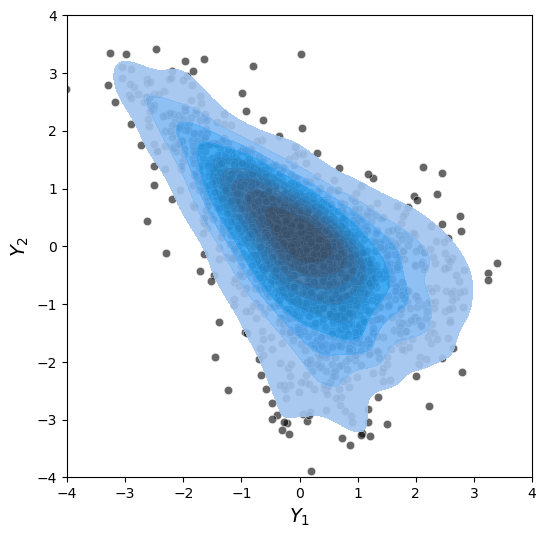

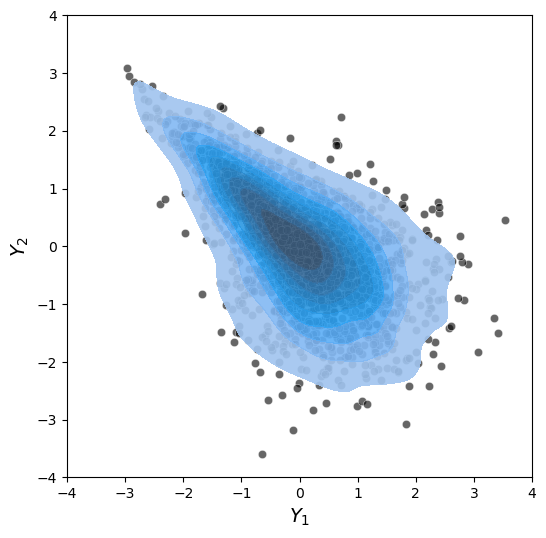

In [19]:
_ = plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
_ = plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [20]:
synthetic_samples = model.sample(2000)
p_matrix = model.compute_precision_matrix(synthetic_samples)

In [21]:
conditional_correlation_matrix_train = model.compute_correlation_matrix(synthetic_samples)
conditional_correlation = conditional_correlation_matrix_train[:,0,1]

ValueError: Per-column arrays must each be 1-dimensional

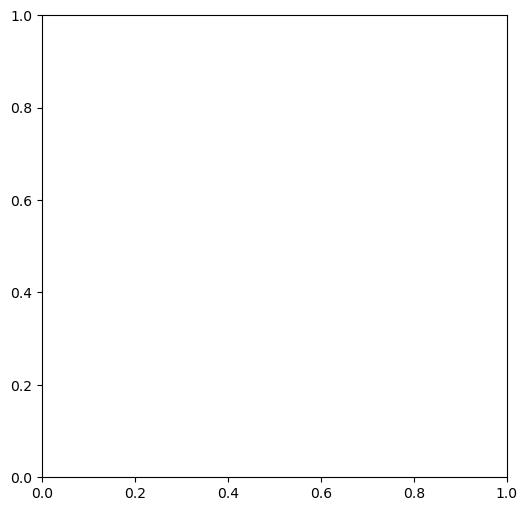

In [22]:
_ = plot_metric_scatter(data=synthetic_samples,metric=conditional_correlation_matrix_train)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots/plot_splines.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, spline_num],


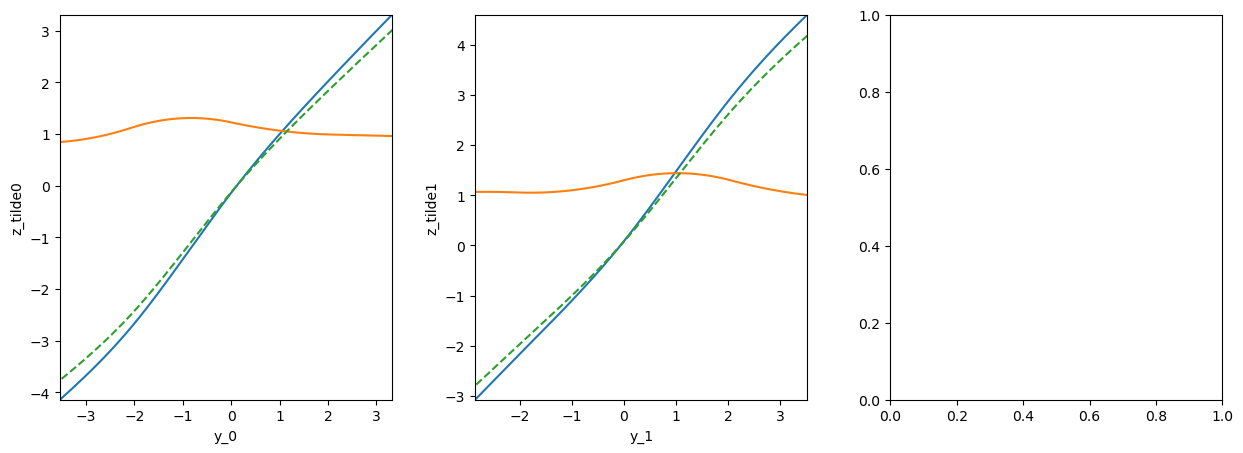

In [ ]:
_ = plot_splines(model.transformation,simulated_data_train)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots/plot_splines.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, col_indices],


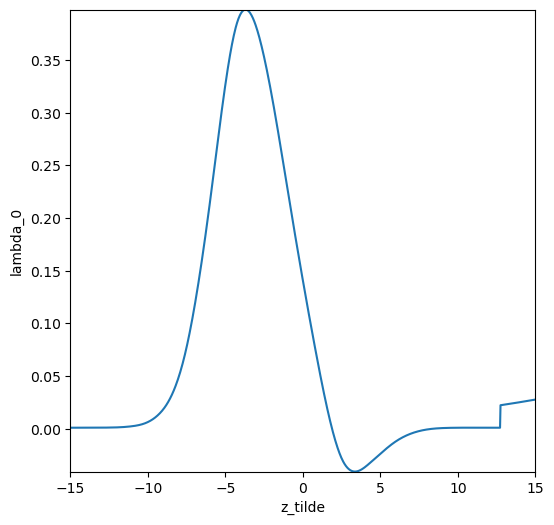

In [ ]:
_ = plot_splines(model.decorrelation_layers[0],simulated_data_train)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots/plot_splines.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, col_indices],


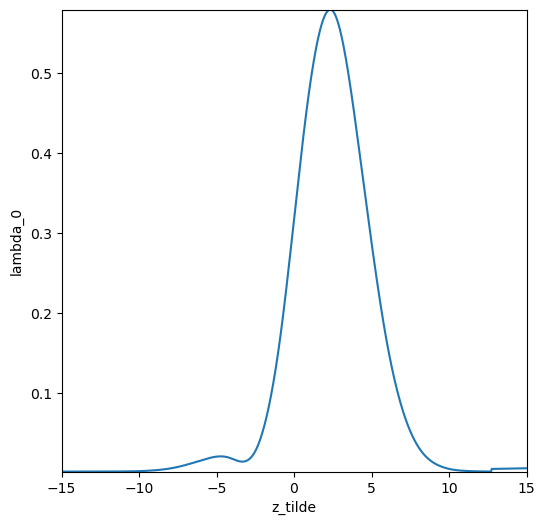

In [ ]:
_ = plot_splines(model.decorrelation_layers[1],simulated_data_train)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots/plot_splines.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, col_indices],


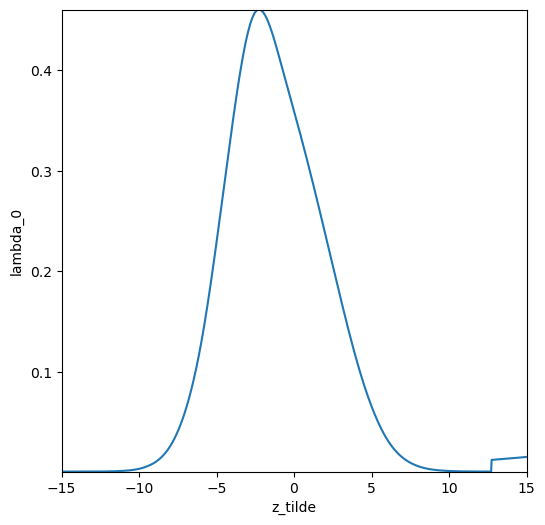

In [ ]:
_ = plot_splines(model.decorrelation_layers[2],simulated_data_train)